In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')[:-1]
print(len(train_data), len(test_data))

train= train_data
test = test_data.apply(pd.to_numeric)

68636 29413


In [13]:
X = train.drop("signal", axis=1)
X = (X-X.mean())/X.std()
train = X.join(train["signal"])

XX = test.drop("signal", axis=1)
XX = (XX-XX.mean())/XX.std()
test = XX.join(test["signal"])

In [14]:
from scipy.stats import ks_2samp
train_stat, train_p = [], []

for i in range(len(train.keys())-1):
    train_stat = np.append(train_stat,ks_2samp(train.query('signal==0')[train.keys()[i]],train.query('signal==1')[train.keys()[i]])[0])
    train_p = np.append(train_stat,ks_2samp(train.query('signal==0')[train.keys()[i]],train.query('signal==1')[train.keys()[i]])[1])


train_list = dict(zip(train.keys()[:-1],train_stat))
train_list_sorted = dict(sorted(train_list.items(), key=lambda item: item[1]))
train_list_sorted


{'missing_energy_phi': 0.003254063696343179,
 'lepton_phi': 0.005250537605601402,
 'jet1phi': 0.006744408012343661,
 'jet3phi': 0.007694254995927352,
 'jet4phi': 0.008105746088170163,
 'jet2phi': 0.008137114722488237,
 'm_lv': 0.010386893995635749,
 'lepton_eta': 0.010518898163357937,
 'jet1b.tag': 0.012580087397600026,
 'jet3pt': 0.012693279584993333,
 'id': 0.01269965758149394,
 'jet1eta': 0.014007216717948245,
 'jet3eta': 0.014504340101392843,
 'jet4b.tag': 0.015875851281828557,
 'jet2eta': 0.0173633309139285,
 'm_jj': 0.017681132670639033,
 'jet4eta': 0.019486671326037097,
 'jet3b.tag': 0.02494816071865935,
 'jet2pt': 0.02846273239147512,
 'jet4pt': 0.030942537809816595,
 'lepton_pT': 0.03858265522652582,
 'jet2b.tag': 0.049864347970956235,
 'm_jlv': 0.05341320850942499,
 'jet1pt': 0.06990101266799159,
 'missing_energy_magnitude': 0.07262518556598518,
 'm_jjj': 0.09632140613997875,
 'm_wbb': 0.1070652762675185,
 'm_wwbb': 0.1517473764300511,
 'm_bb': 0.1960046638615971}

In [15]:
def act_f(xvals):
    return 1/(1+np.exp(-xvals))

def f_cost(y, xvals):
    return (1/2) * (y - xvals)**2

def der_f_act(xvals):
    return np.exp(-xvals)/(1+np.exp(-xvals))**2
    #return f_act(x_input) * (1 - f_act(x_input))

def der_f_cost(y, xvals):
    return -(y - xvals)

In [16]:
#np.random.seed(12)
def bias_vector(n_nodes):
    return np.array(np.random.uniform(-1,1,n_nodes))
    #return np.ones(n_nodes)

def initialize_all_bias(n_hidden_nodes,n_hidden_layers):
    all_bias_nodes = []
    for _ in range(n_hidden_layers):
        all_bias_nodes.append(bias_vector(n_hidden_nodes))
    all_bias_nodes.append(bias_vector(1))
    
    return all_bias_nodes
    
def init_weight_mat(n_next,n_previous):
    return np.array(np.random.uniform(-1,1,[n_next,n_previous]))
    #return np.ones([n_next,n_previous])


def initialize_all_weight_matrices(n_input_features, n_hidden_nodes, n_hidden_layers):
    
    list_of_nodes = [n_input_features]
    for _ in range(n_hidden_layers):
        list_of_nodes.append(n_hidden_nodes)
    list_of_nodes.append(1)
    
    all_weight_matrices = []
    for i in range(len(list_of_nodes)-1):
        all_weight_matrices.append(init_weight_mat(list_of_nodes[i+1],list_of_nodes[i]))

    #[number of inputs][number of hidden nodes][number of input layers]
    return all_weight_matrices

def input_sum(weights, inputs, bias):
    return np.dot(weights,inputs) + bias



In [17]:
def forward_prop(input_features, n_hidden_nodes, n_hidden_layers, weight_list_dummy, bias_list_dummy):

    
    x_list = input_features
    z_list, act_z_list = [], []

    for layer in range(len(weight_list_dummy)):
        
        z_list.append((np.dot(weight_list_dummy[layer], x_list).transpose() + bias_list_dummy[layer]).transpose())
        act_z_list.append(act_f(np.dot(weight_list_dummy[layer], x_list).transpose() + bias_list_dummy[layer]).transpose())

        x_list = act_z_list[-1]
    act_z_list.insert(0,np.array(input_features))
    
    
    
    # for 1st two vars :[# var][layer number][node number][data number]            
    return z_list, act_z_list, weight_list_dummy, bias_list_dummy

In [64]:
# function to initialize errors for each node (set to 0 at start)
def initialize_node_error(n_hidden_nodes,n_hidden_layers):
    all_nodes = []
    for _ in range(n_hidden_layers):
        all_nodes.append([0] * n_hidden_nodes)
    all_nodes.append([0])
    
    return all_nodes
    
def back_prop(true_values, z_list, act_z_list, weight_list, bias_list, input_features):
    
    cost_cal = np.sum(f_cost(true_values, act_z_list[-1]))
    output_error = der_f_cost(true_values, act_z_list[-1][0]) 
    lrate = 10 / len(true_values)
    
    # to store weights...
    #weight_epochs, bias_epochs = []
    #weight_epochs.append(weight_list)
    #bias_epochs.append(bias_list)
    
    # np.shape(weight_list[1])[1] = no. of hidden nodes
    # len(weight_list[:-1]) = no. of hidden layers
    
    error_node_matrix = initialize_node_error(np.shape(weight_list[-1])[1], len(weight_list[:-1]))

    error_node_matrix[-1][0] = output_error * der_f_act(z_list[-1][0])

    for layer in range(len(weight_list)-1,0,-1): 
        
        for node in range(np.shape(weight_list[layer])[1]):
            
            for each_weight in range(np.shape(weight_list[layer][0])[0]): 
                
                if layer==len(weight_list)-1:
 
                    error_node_matrix[layer-1][node] +=( weight_list[layer][0][each_weight] * 
                                                      error_node_matrix[layer][0] * 
                                                      der_f_act(z_list[layer-1][node]) )
                    
                if layer<len(weight_list)-1:
                
                    error_node_matrix[layer-1][node] +=( weight_list[layer][each_weight][node] * 
                                                      error_node_matrix[layer][each_weight] * 
                                                      der_f_act(z_list[layer-1][node]) )
 
    
    for layer in range(len(weight_list)):    
        
        for node in range(np.shape(weight_list[-layer-1])[0]):
            
            for each_weight in range(np.shape(weight_list[-layer-1][node])[0]):
                    
                if layer!=(len(weight_list)-1):
                    
                    weight_list[-layer-1][node][each_weight] -= np.sum(lrate * act_z_list[-layer-2][each_weight] *
                                                          error_node_matrix[-layer-1][node])
                    
                if layer==(len(weight_list)-1):
                    weight_list[-layer-1][node][each_weight] -= np.sum(lrate * input_features[each_weight] *
                                                          error_node_matrix[-layer-1][node])
                
                bias_list[-layer-1][node] -=  np.sum(lrate * error_node_matrix[-layer-1][node])
                    
    
    return weight_list, bias_list, cost_cal

def train_network(input_features, n_hidden_nodes, n_hidden_layers, true_values,epochs):
    
    weight_list = initialize_all_weight_matrices(len(input_features), n_hidden_nodes, n_hidden_layers)
    bias_list = initialize_all_bias( n_hidden_nodes, n_hidden_layers)
    cost_all = np.array([])
    for epochs_i in range(epochs):
        z_list_i, act_z_list_i, weight_list_i, bias_list_i = forward_prop(input_features, n_hidden_nodes, 
                                                                          n_hidden_layers, weight_list, bias_list)
        
        weights_updated, bias_updated, cost_dum = back_prop(true_values, z_list_i, act_z_list_i, weight_list_i, 
                                                  bias_list_i, input_features)
        weight_list_i = weights_updated
        bias_list_i = bias_updated
        
        cost_all = np.append(cost_all,cost_dum)
        print(epochs_i+1, end=" ")
        
        
    return weights_updated, bias_updated, cost_all

In [65]:
#d_index = 10000
#input_vector = np.array([train['m_bb'][:d_index],train['m_wwbb'][:d_index],train['m_wbb'][:d_index]])
input_vector = np.array([train['m_bb'],train['m_wwbb'],train['m_wbb']])
#true_vector = np.array(train['signal'][:d_index])
true_vector = np.array(train['signal'])

all_arr = train_network(input_vector,3,1,true_vector,1000)



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

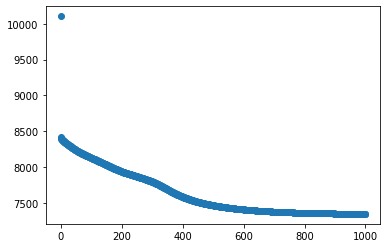

In [63]:
plt.scatter(np.arange(0,len(all_arr[2]),1),all_arr[2])
plt.show()

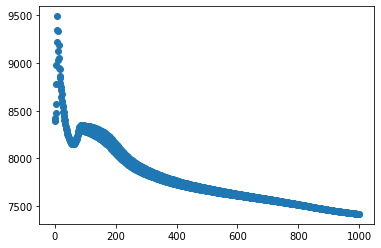

In [66]:
plt.scatter(np.arange(0,len(all_arr[2]),1),all_arr[2])
plt.show()

In [51]:
def test_network(input_test_vector, weights_trained, bias_trained):
    
    x_test_list = input_test_vector
    z_test_list, act_z_test_list = [], []     
    for layer in range(len(weights_trained)):

        z_test_list.append((np.dot(weights_trained[layer], x_test_list).transpose() + bias_trained[layer]).transpose())
        act_z_test_list.append(act_f(np.dot(weights_trained[layer], x_test_list).transpose() + bias_trained[layer]).transpose())

        x_test_list = act_z_test_list[-1]
    act_z_test_list.insert(0,np.array(input_test_vector))
    
    # for 1st two vars :[# var][layer number][node number][data number]            
#    return z_test_list, act_z_test_list
    return act_z_test_list[-1][0]




In [52]:
test_vector = np.array([test['m_bb'],test['m_wwbb'],test['m_wbb']])

test_output = test_network(test_vector,all_arr[0],all_arr[1])

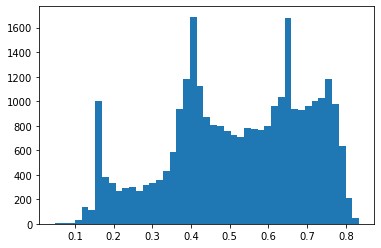

In [53]:
plt.hist(test_output,bins='auto')

plt.show()

ROC score for  m_bb 0.5538334386750075
ROC score for  m_wwbb 0.567830783780928
ROC score for  m_wbb 0.5171133577631016
ROC score for  MLP output 0.7152742254515561


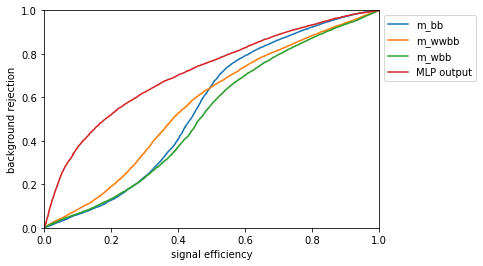

In [68]:
feats = ['m_bb','m_wwbb','m_wbb']#,'m_jjj']

from sklearn.metrics import roc_curve, roc_auc_score
def left_right_ordered_feature(sample, f):
    mean_sig = np.mean(sample[f][sample["signal"] == 1])
    mean_bkg = np.mean(sample[f][sample["signal"] == 0])
    if mean_bkg < mean_sig:
        return sample[f]
    else:
        return -sample[f]

for label,value in [(f, left_right_ordered_feature(test, f)) for f in feats]+[("MLP output", test_output)]:
    fpr, tpr, thresh = roc_curve(test["signal"], value)
    
    #plt.plot(tpr, 1-fpr, label=label)
    plt.plot(fpr, tpr, label=label)
    print("ROC score for ",label,roc_auc_score(test["signal"], value))

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('signal efficiency')
plt.ylabel('background rejection')
plt.legend(bbox_to_anchor=(1,1), loc="upper left");
plt.show()

ROC score for  m_bb 0.5538334386750075
ROC score for  m_wwbb 0.567830783780928
ROC score for  m_wbb 0.5171133577631016
ROC score for  MLP output 0.7152742254515561


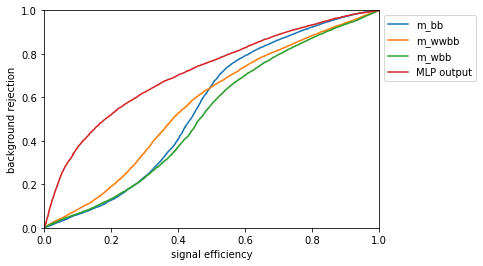

area = 0.5757407726812027


In [73]:
feats = ['m_bb','m_wwbb','m_wbb']#,'m_jjj']

from sklearn.metrics import roc_curve
def left_right_ordered_feature(sample, f):
    mean_sig = np.mean(sample[f][sample["signal"] == 1])
    mean_bkg = np.mean(sample[f][sample["signal"] == 0])
    if mean_bkg < mean_sig:
        return sample[f]
    else:
        return -sample[f]

for label,value in [(f, left_right_ordered_feature(test, f)) for f in feats]+[("MLP output", test_output)]:
    fpr, tpr, thresh = roc_curve(test["signal"], value)
    #plt.plot(tpr, 1-fpr, label=label)
    plt.plot(fpr, tpr, label=label)
    print("ROC score for ",label,roc_auc_score(test["signal"], value))

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('signal efficiency')
plt.ylabel('background rejection')
plt.legend(bbox_to_anchor=(1,1), loc="upper left");
plt.show()

from scipy.integrate import simps
area_p = simps(tpr, dx=fpr[1])
print("area =", area_p)

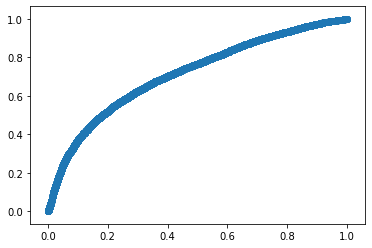

In [75]:
plt.scatter(fpr,tpr)